In [2]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
os.chdir("../")


import jax.numpy as np
import matplotlib.pyplot as plt
import pickle

from jax import random, vmap, jit
from tensorflow_probability.substrates import jax as tfp

import nrmifactors.priors as priors
from nrmifactors import algorithm as algo
from nrmifactors.state import State
from spatial_simu.run_mcmc import get_true_dens


tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
import numpy as onp

@jit
def eval_densities(xgrid, lam, m, j, atoms):
    weights = np.matmul(lam, m) * j
    weights /= weights.sum(axis=1)[:, np.newaxis]
    eval_comps = tfd.Normal(loc=atoms[:, 0], scale=np.sqrt(atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens = eval_comps[:, np.newaxis, :] * weights[np.newaxis, :, :]
    dens = np.sum(dens, axis=-1).T
    return dens


def inv_alr(x):
    out = onp.exp(np.hstack((x, 0)))
    return np.array(out / np.sum(out))


def get_weights(Nx, Ny):

    N = Nx*Ny
    centers = onp.zeros((N, 2))
    for i in range(Nx):
        for j in range(Ny):
            centers[i + j*Nx, :] = np.array([i + 0.5, j + 0.5])
    c = 0.3
    alpha1 = c
    alpha2 = -c
    beta1 = c
    beta2 = -c

    weights = []
    mean_centers = np.mean(centers, axis=0)
    for center in centers:
        w1 = alpha1 * (center[0] - mean_centers[0]) \
             + beta1 * (center[1] - mean_centers[1])
        w2 = alpha2 * (center[0] - mean_centers[0]) \
            + beta2 * (center[1] - mean_centers[1])
        weights.append(inv_alr([w1, w2]))

    return np.array(weights)

# Quantitative Analysis

In [ ]:
true_atoms = np.array([
    [-5, 1],
    [0, 1],
    [5, 1]
]).astype(float)

In [ ]:
xgrid = np.linspace(-10, 10, 1000)

kl = []
hell = []

for nx in [4, 8, 16]:
    true_dens = get_true_dens(xgrid, get_weights(nx, nx), true_atoms)
    curr_kl = []
    curr_hell = []
    
    for nlat in [1, 3, 5, 10]:
        chains_file = "spatial_simu/chains_groups_{0}_lat_{1}.pickle".format(nx * nx, nlat)
        with open(chains_file, "rb") as fp:
            chains = pickle.load(fp)
            
        lam_chain = np.stack([x.lam for x in chains])
        m_chain = np.stack([x.m for x in chains])
        j_chain = np.stack([x.j for x in chains])
        atoms_chain = np.stack([x.atoms for x in chains])
        
        dens_chain = vmap(lambda lam, m, j, atoms: eval_densities(xgrid, lam, m, j, atoms))(
                lam_chain, m_chain, j_chain, atoms_chain
        )
        
        est_dens = np.nanmean(dens_chain, axis=0)
        
        kl_integrand = true_dens * (np.log(true_dens) - np.log(est_dens))
        kls = np.trapz(kl_integrand, xgrid)
        curr_kl.append(np.mean(kls))
        
        hell_integrand = (np.sqrt(true_dens) - np.sqrt(est_dens))**2 * 0.5
        hells = np.trapz(hell_integrand, xgrid)
        curr_hell.append(np.mean(hells))
    kl.append(curr_kl)
    hell.append(curr_hell)

In [ ]:
with open("spatial_simu/kl_hell_from_true.pickle", "wb") as fp:
    pickle.dump({"nlat": [1, 3, 5, 10], "kl": kl, "hell": hell}, fp)

In [8]:
with open("spatial_simu/kl_hell_from_true.pickle", "rb") as fp:
    tmp = pickle.load(fp)
    kl = tmp["kl"]
    hell = tmp["hell"]

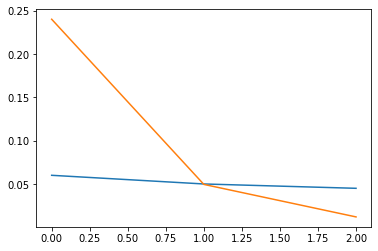

In [35]:
hdp_kl = [6 * 1e-2, 5 * 1e-2, 4.5 * 1e-2]
spmix_kl = [0.24, 4.95 * 1e-2, 0.12 * 1e-1]


plt.plot(hdp_kl)
plt.plot(spmix_kl)

In [43]:
np.min(np.array(kl))

DeviceArray(0.01024944, dtype=float64)

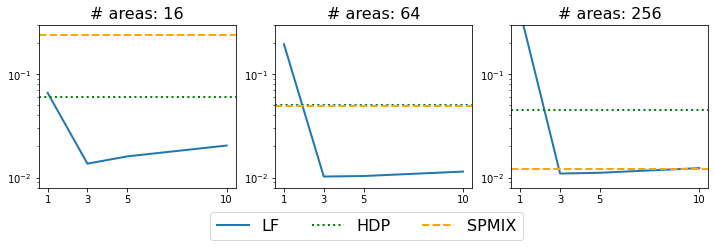

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

n_areas = [16, 64, 256]

for i in range(3):
    axes[i].plot([1, 3, 5, 10], kl[i], lw=2, label="LF")
    axes[i].axhline(y=hdp_kl[i], linestyle=":", lw=2, color="green", label="HDP")
    axes[i].axhline(y=spmix_kl[i], linestyle="--", lw=2, color="orange", label="SPMIX")
    axes[i].set_xticks([1, 3, 5, 10])
    axes[i].set_title("# areas: {0}".format(n_areas[i]), fontsize=16)
    axes[i].set_yscale("log")
    axes[i].set_ylim((0.008, 0.3))
    
axes[1].legend(ncol=3, bbox_to_anchor=(1.3, -0.1), fontsize=16)    
plt.savefig("spatial_simu/spatial_kl.pdf", bbox_inches="tight")

# Plots

In [68]:
nx = 8
nlat = 3

chains_file = "spatial_simu/chains_groups_{0}_lat_{1}.pickle".format(nx * nx, nlat)
with open(chains_file, "rb") as fp:
    states = pickle.load(fp)

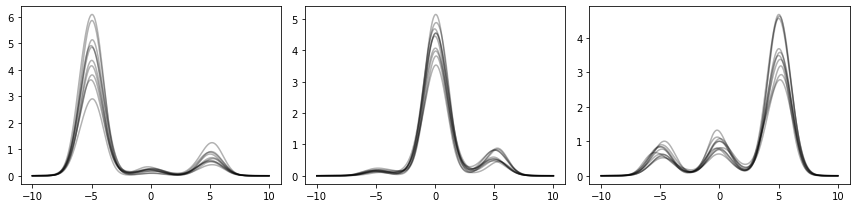

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=nlat, figsize=(12, 3))

idx = np.arange(-1000, 0, 100)
xgrid = np.linspace(-10, 10, 1000)

for j in sorted(idx):
    state = states[j]

    eval_comps = tfd.Normal(
        loc=state.atoms[:, 0], scale=np.sqrt(state.atoms[:, 1])).prob(xgrid[:, np.newaxis])
    dens_lat = eval_comps[:, np.newaxis, :] * (state.m * state.j)[np.newaxis, :, :]
    dens_lat = np.sum(dens_lat, axis=-1).T    


    for i in range(nlat):
        axes[i].plot(xgrid, dens_lat[i, :], color="black", alpha=0.3)

plt.tight_layout()
plt.savefig("spatial_simu/latent_meas.pdf", bbox_inches="tight")